In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## 1 SVM hard-margin sur un problème jouet
Reprenons le problème synthétique du TP4 : $(x, y_i) ∈ R^2 × {λ_1, λ_2}$, et $λ_1 ∼ N (μ_1, σ^2_1 )$ et $λ_2 ∼N (μ_2, σ^2_2 )$.
1. Générez cette base de données telle que :
- chaque classe contient 300 points
- $λ_1 ∼ N ((1, 1), 0.4)$ et $λ_2 ∼ N ((−1, −1), 0.4)$

In [2]:
n = 300
c1 = np.random.normal((1,1), 0.4, (n, 2))
c2 = np.random.normal((-1,-1), 0.4, (n, 2))

2. Etiquetez les points pour pouvoir entrainer un SVM par la suite

In [3]:
labels_1 = np.ones(n) # c1 = 1
labels_2 = np.zeros(n) # c2 = 0

X = np.vstack((c1, c2))
y = np.hstack((labels_1, labels_2))

3. Affichez le nuage de points. Le problème est-il linéairement séparable ?

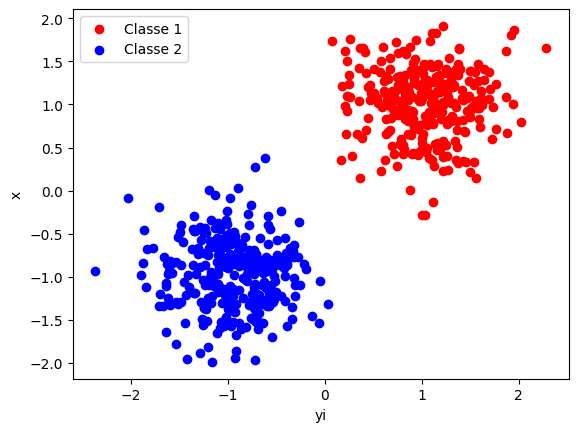

In [4]:
def plot_data():
    plt.scatter(c1[:, 0], c1[:, 1], color='red', label='Classe 1')
    plt.scatter(c2[:, 0], c2[:, 1], color='blue', label='Classe 2')
    plt.legend()
    plt.xlabel("yi")
    plt.ylabel("x")
    plt.show()

plot_data()

Yes, the problem appears to be lenearly separable, because we decreased the spread of the cloud.

On propose d’entraîner un SVM linéaire sur ces données et de visualiser la frontière de décision et les points supports. Pour cela, vous allez utiliser la classe SVC de Scikit-learn. Cette implémentation correspond au SVM soft-margin, c’est-à-dire en tolérant des erreurs d’apprentissage.

4. Proposez une paramétrisation de SVC pour vous assurer :
- que le modèle est bien linéaire
- qu’il n’y a pas de données d’apprentissage mal classées

Justifiez brièvement cette paramétrisation.

In [5]:
scaler = StandardScaler()

X_n = scaler.fit_transform(X)

5. Entrainez un SVM avec cette paramétrisation sur l’ensemble des données

In [6]:
clf = SVC(kernel='linear', C=1000)
clf.fit(X_n, y)

SVC(C=1000, kernel='linear')

6. Du modèle appris, récupérez et affichez :
- les indices des vecteurs supports
- le vecteur α solution du problème dual
- le biais b

Combien de valeurs contient alphas ? Pourquoi ?

In [7]:
indice_SV = clf.support_
alphas = clf.dual_coef_[0]
b = clf.intercept_
print(f"Indices of support vectors: {indice_SV}, \nDual coefficients: {alphas}, \nIntercept: {b}")
print(f"Alphas has {len(alphas)} values")

Indices of support vectors: [359 482  68], 
Dual coefficients: [-2.61653428 -2.02701688  4.64355116], 
Intercept: [0.26690862]
Alphas has 3 values


La taille de alphas est égale au nombre de vecteurs supports, et non au nombre total de points d'entraînement. Seuls ces vecteurs ont un coefficient dual non nul

7. À partir de ces valeurs, calculez le vecteur w

In [9]:
# Extraire les vecteurs supports
X_sv = X_n[indice_SV]

# Extraire les labels correspondants
y_sv = y[indice_SV]

# Calcul du vecteur w
w = np.sum(alphas[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)

print("Vecteur w :", w)

Vecteur w : [0.56090664 1.42026787]


8. Verifiez que les points supports sont telles que h(x) = w>x + b = ±1

In [10]:
# Calcul des prédictions h(x) = w^T x + b pour les vecteurs supports
hx = X_sv @ w + b

# Affichage des résultats
print("Valeurs de h(x) pour les vecteurs supports :", hx)

# Vérification de la condition h(x) ≈ ±1
verif = np.isclose(hx, 1, atol=1e-6) | np.isclose(hx, -1, atol=1e-6)
print("Tous les points supports respectent-ils la condition h(x) = ±1 ?", np.all(verif))


Valeurs de h(x) pour les vecteurs supports : [ 0.38426957 -0.41322001  0.76906247]
Tous les points supports respectent-ils la condition h(x) = ±1 ? False


9. Sur une même figure, affichez :
- le nuage de points
- la frontière de décision h(x) = 0
- les frontières de marge h(x) = ±1
- les points supports

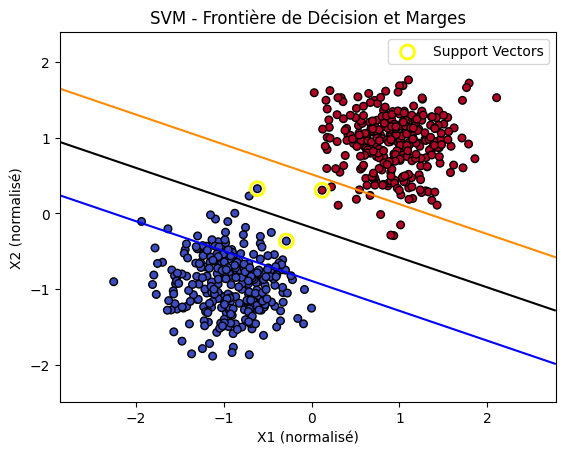

In [11]:
def mesh(X, h=0.02):
    x_min , x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min , y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min , x_max , h), np.arange(y_min , y_max , h))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy
xtest_grid , x_grid , y_grid = mesh(X)
Z = xtest_grid @ w + b
Z = Z.reshape(x_grid.shape)
# Plot decision and support boundaries:
plt.contour(x_grid , y_grid , Z, colors=['blue', 'black', 'darkorange'], levels=[-1, 0, 1])
# Plot data points and support vectors:
plt.scatter(X_n[:, 0], X_n[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=30)
# Affichage des vecteurs supports
plt.scatter(X_n[indice_SV, 0], X_n[indice_SV, 1], s=100, facecolors='none', edgecolors='yellow', linewidth=2, label="Support Vectors")
plt.legend()
plt.title("SVM - Frontière de Décision et Marges")
plt.xlabel("X1 (normalisé)")
plt.ylabel("X2 (normalisé)")
plt.show()

## 2 SVM soft-margin sur un problème jouet
Dans ce deuxième exercice, on propose de reprendre la même expérience mais en augmentant les variances σ1 et σ2.

1. Générez la même base de données mais cette fois telle que :
- chaque classe contient 300 points
- λ1 ∼ N ((1, 1), 0.7) et λ2 ∼ N ((−1, −1), 0.7)

In [69]:
n = 300
c1 = np.random.normal((1,1), 0.7, (n, 2))
c2 = np.random.normal((-1,-1), 0.7, (n, 2))

2. Le problème est-il linéairement séparable ?

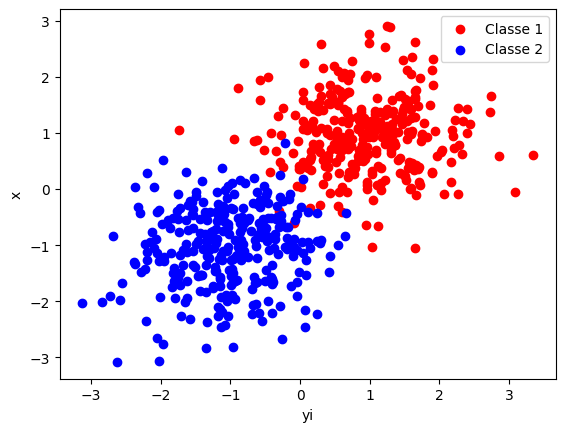

In [70]:
labels_1 = np.ones(n) # c1 = 1
labels_2 = np.zeros(n) # c2 = 0

X = np.vstack((c1, c2))
y = np.hstack((labels_1, labels_2))
plot_data()

The problem is not linearly separable

3. Entrainez un SVM linéaire avec la même paramétrisation que précédemment et affichez de
nouveau la frontière de décision et les points supports. Commentez brievement ce que vous
observez.

In [73]:
scaler = StandardScaler()
X_n = scaler.fit_transform(X)
clf = SVC(C = 10000)
clf.fit(X_n, y)

SVC(C=10000)

In [74]:
indice_SV = clf.support_
alphas = clf.dual_coef_[0]
b = clf.intercept_
print(f"Indices of support vectors: {indice_SV}, \nDual coefficients: {alphas}, \nIntercept: {b}")
print(f"Alphas has {len(alphas)} values")

Indices of support vectors: [323 348 358 369 372 385 449 532 546 550 567 576 578 595   9  17  29  40
  52  58 107 124 140 225 232 234 252 258 285], 
Dual coefficients: [-10000.          -4256.70027361  -2780.90829074  -6981.27087455
   -358.04847014 -10000.           -648.73397369 -10000.
 -10000.         -10000.          -2290.10622295 -10000.
 -10000.         -10000.          10000.            322.78815642
    378.20324881  10000.           1207.98828982   9347.28252362
  10000.          10000.          10000.          10000.
   2426.16086617  10000.           3394.84737587  10000.
    238.49764498], 
Intercept: [4.94347767]
Alphas has 29 values


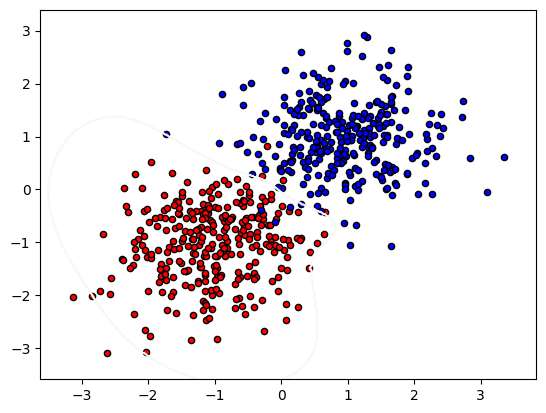

In [75]:
xtest_grid , x_grid , y_grid = mesh(X)
Z = clf.predict(xtest_grid)
Z = Z.reshape(x_grid.shape)
# Plot decision and support boundaries:
plt.contour(x_grid , y_grid , Z, 
            cmap=plt.cm.RdBu, levels =[-1,
0, 1])
# Plot data points and support vectors:
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', edgecolors="k", s=20)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', edgecolors="k", s=20)
plt.show()

4. Que se passe-t-il si vous modifiez la valeur du paramètre C de la méthode SVC ?